<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Time series first notebook</h1>
#### Thanks again to Leo Siqueira for contributions

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#stationary">First thing: establishing stationarity</a>
1. <a href="#composing">Composing a sum of Fourier harmonics</a>
1. <a href="#decomposing">Decomposing, using orthogonality</a>
1. <a href="#spectrum">Variance density by frequency (power spectrum)</a>
1. <a href="#autocorrelation">Lagged (auto) correlation/covariance</a>
1. <a href="#AR1noise">AR1 model of geophysical processes</a>

--------

<a name="stationary"></a>
### Stationary Processes

A "process" (time series) X(t) is said to be **Weakly Stationary** if the mean $\mu_X(t)$ and the *lag covariance* $C_{XX}(t,t+\tau) = \overline{X_t \cdot X_{t+\tau}}$ are independent of time $t$. 
A process is said to be **Strongly Stationary** if _all possible probability distributions_ are independent of $t$.  Since this is hard to prove as a practical matter in data, it is just a math distinction, mainly of academic value.

A special category of *weakly stationary* is **ergodic** processes with the property that "given sufficient time, they include or impinge on all points in a given space, and can be represented statistically by a reasonably large selection of points." As scientists, this is what we usually assume. Formally a process is **ergodic** if

\begin{align}
    \mu_X(k) &= \lim_{T\to\infty} \frac{1}{T}\int_0^T X(t)\ \mathrm{d}t\\
    C_{XX}(\tau,k) &= \lim_{T\to\infty}  \frac{1}{T}\int_0^T \left( X_k(t)-\mu_X(t) \right)\left( X_k(t+\tau)-\mu_X(t+\tau) \right)\ \mathrm{d}t\\
\end{align}

-----------

<a name="composing"></a>
### Loading time series from a Matlab file (.mat)

These rain rate time series come from my uncoupled and coupled experiments of the same MJO event starting on Oct 18, 2011. Each experiment is run for 14 days 

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
# GridSpec lets us align plots carefully 
from matplotlib import gridspec

import scipy.stats as stats
import numpy as np
from numpy.random import rand
from pylab import rcParams, pcolor, show, colorbar, xticks, yticks, title, figure
from scipy.io import loadmat #This allows python to read a Matlab file
from datetime import datetime, timedelta #Need this to convert matlab time to python time

rcParams['figure.figsize'] = (14, 7)

In [6]:
#Read in our timeseries
data = loadmat('/Users/newumuser/Documents/GitHub/DATA/rr_timeseries.mat')
coup_rr = data['coup_rr']
ctl_rr = data['ctl_rr']
lat = data['lat']
lon = data['lon']

lat_10 = lat[:,0]
lat_10_index = np.where((lat_10 <= 10) & (lat_10 >= -10))
lat_index = lat_10_index[0]

lon_60_90 = lon[0,:]
lon_60_90_index = np.where((lon_60_90 <= 90) & (lon_60_90 >= 60))
lon_index = lon_60_90_index[0]

coup_rr_less = coup_rr[:,lat_index[0]:lat_index[-1],lon_index[0]:lon_index[-1]] #only want rain over central Indian Ocean
coup_rr_less.shape

coup_rr_t = np.mean(np.mean(coup_rr_less,axis=1),axis=1)
coup_rr_t.shape

t = np.array(range(0,337))
t.shape

(337,)

In [3]:
def fig1():
    fig=plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax=fig.add_subplot(gs[0])
    ax.plot(t,coup_rr_t)
    ax.set_xlabel('time [hours]');ax.set_ylabel('Rain Rate [mm/h]');
    ax=fig.add_subplot(gs[1]); ax.set_xlabel('PDF & normal approx.')
    n,bins,pa=ax.hist(coup_rr_t,101,orientation='horizontal', \
                      normed='True',label='pdf of rr')
    # Approximate it with a normal distribution of same mean and std
    normapprox = stats.norm.pdf(bins,loc=np.mean(coup_rr_t),scale=np.std(coup_rr_t)) 
    ax.plot(normapprox, bins)

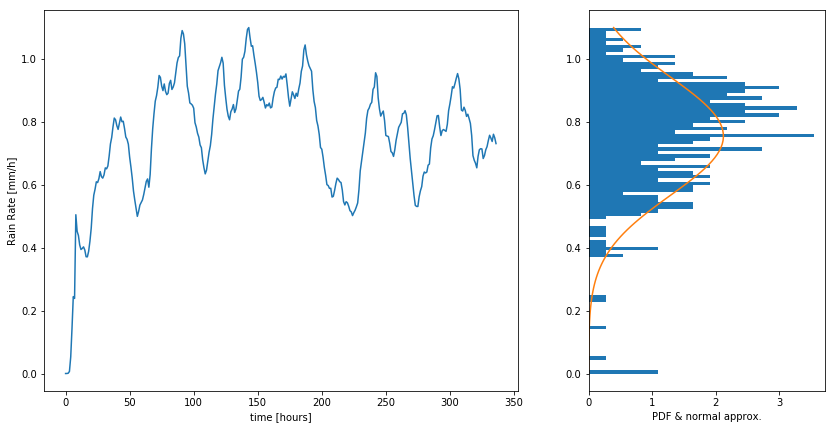

In [7]:
fig1()

<a name="decomposing"></a>
### Decomposing time series: find the sines and cosines

Project a series onto pure cosine -- it gives the coefficient!  

Text(0.5,1,'This component has amplitude -0.0021497018282191334 m/s')

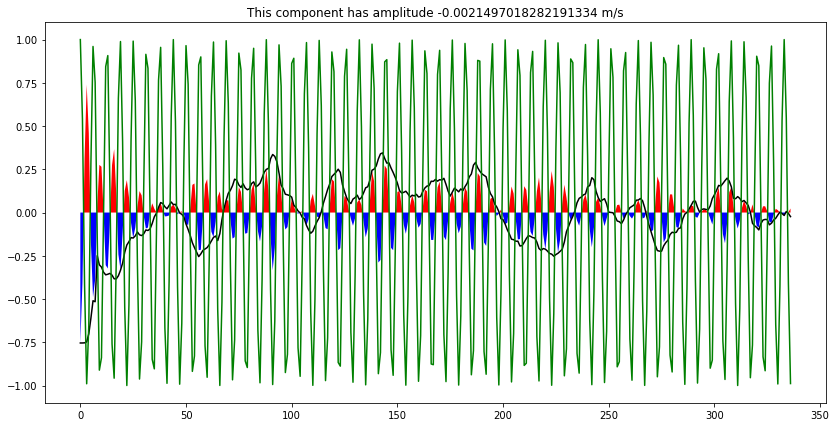

In [14]:
# Candidate frequency 
j=1
rrp = coup_rr_t - coup_rr_t.mean()
fig,ax=plt.subplots(1,1) # Create a figure with series and harmonic
ax.plot(t, rrp, color='black')
ax.plot(t, np.cos(j*t), color='green')

# Show the positive and negative areas of the product of the two
Y = rrp*np.cos(j*t)

ax.fill_between(t, Y, Y*0, where= (Y >= 0), \
                facecolor='red', interpolate=True)
ax.fill_between(t, Y, Y*0, where= (Y <= 0), \
                facecolor='blue', interpolate=True)
ax.set_title('This component has amplitude '+str(Y.mean())+' m/s')

----------------
<a name="spectrum"></a>
### FFT is the "fast" mathemagic for a Fourer transform

Coefficients like the one above make up the _cosine part of the amplitude spectrum_ (the _real part_ of the complex spectrum). The _sine part_ is in the imaginary part. 

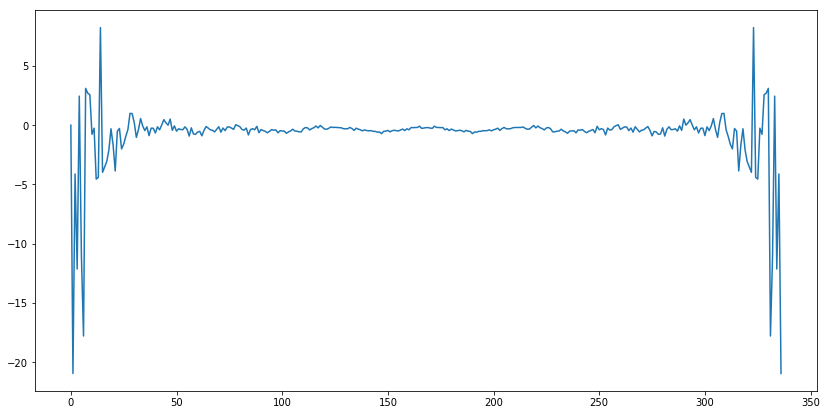

In [15]:
# Take the simple FFT, after removing the mean

rrp = coup_rr_t - coup_rr_t.mean()

#To match the sign above, roll the array so it starts at t=0. 
# Vp = np.roll(Vp, int(-NT/2) ) Too fussy: just know the sign is opposite

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
rrspec = np.fft.fft( rrp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(rrspec.real)
#ax.plot(Vspec.imag)

Text(0,0.5,'Some measure of cosine component amplitude')

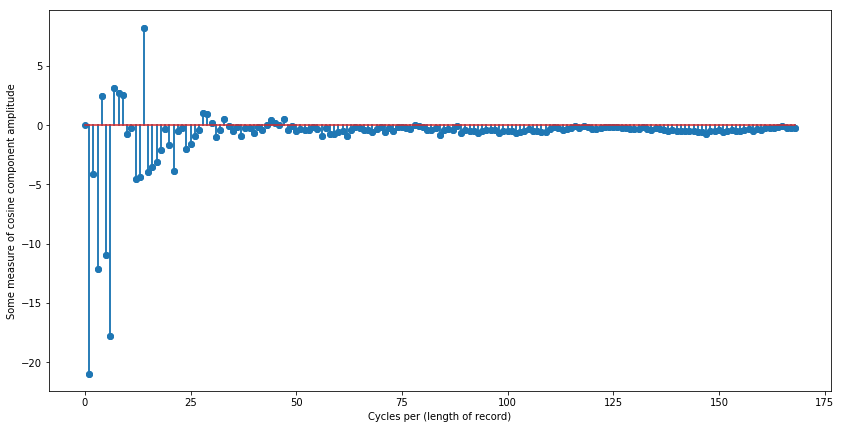

In [18]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
NT = len(t)
freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, rrspec.real)
#ax.set_xlim([0,N + 5])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')

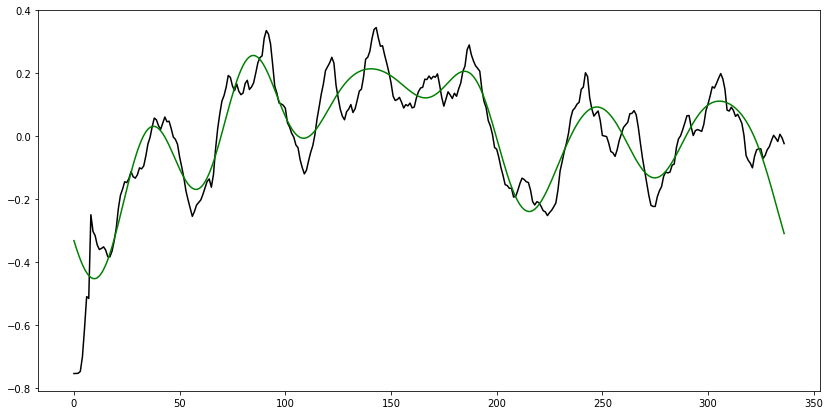

In [21]:
# Mess with the spectrum and reconstruct (a way of filtering)

# Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 10

rrspec_trunc = rrspec.copy()
rrspec_trunc[np.where(freqs > TRUNC)] *= 0. 
rrrecon = np.fft.ifft(rrspec_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(rrp,      color='black')
ax.plot(rrrecon,  color='green')

# Power spectrum is the squared amplitude of the spectrum

Variance is 0.035402197 (mm/h)^2: matches 0.03540219739079478


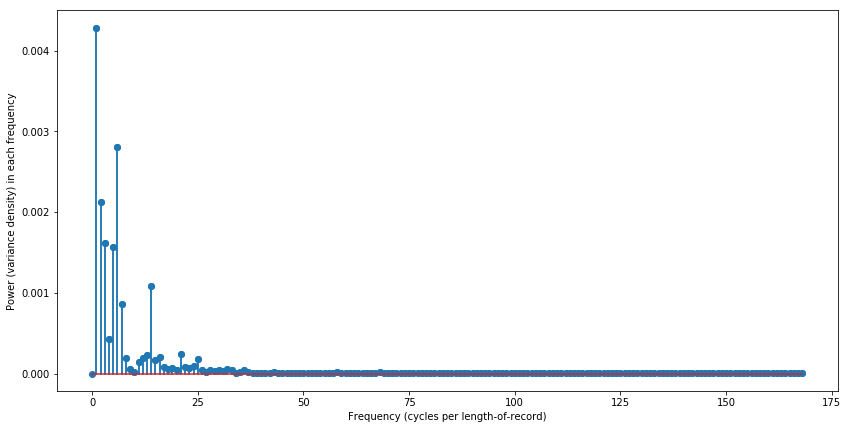

In [22]:
# Complex conjugate does the squaring
Power = (rrspec.conjugate()*rrspec).real
Power *= np.var(rrp) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Power)
#ax.set_xlim([0,N + 5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')

print('Variance is', rrp.var(), '(mm/h)^2: matches', sum(Power))

-------------

# Reconstruction with phase=0 

## Phase spectrum is the complex number's phase angle

Text(0,0.5,'Phase angle atan(cosine_part/sine_part) in each frequency')

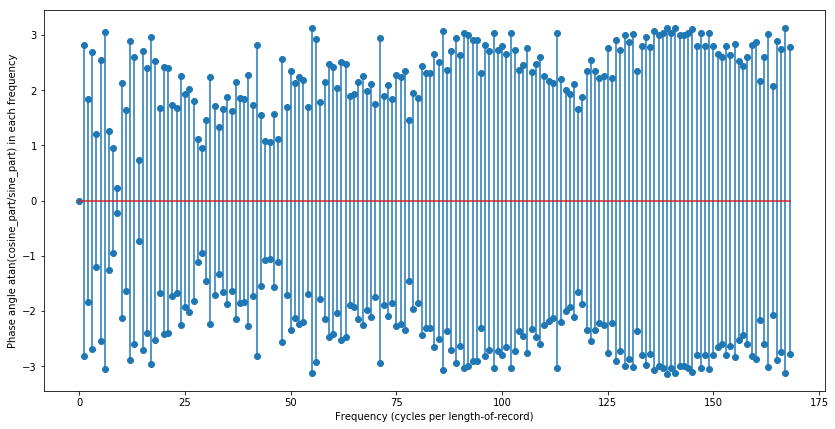

In [23]:
# Phase angle of complex number
Phase = np.angle(rrspec)

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Phase)
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Phase angle atan(cosine_part/sine_part) in each frequency')

0.035402201687223016 0.035402197


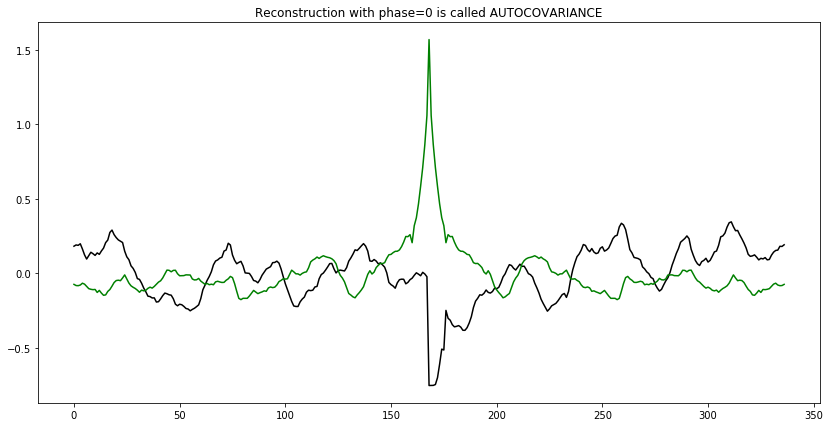

In [24]:
# Reconstruct with phase angle all set to 0 (all components set to pure cosine)
FakePhase = Phase *0 

# Construct a spectrum using that fake phase info
FakeSpec = np.abs(rrspec) * np.exp(1j*FakePhase)
rrrecon = np.fft.ifft(FakeSpec).real

# For clarity, let's roll it into the [-pi,pi] axis
fig,ax=plt.subplots(1,1) 
ax.plot(t, np.roll(rrp,    int(NT/2)), color='black')
ax.plot(t, np.roll(rrrecon,int(NT/2)), color='green')
ax.set_title('Reconstruction with phase=0 is called AUTOCOVARIANCE')

# Has same variance, but all packed at a spike that acts as a sort of "composite excursion"
print(rrrecon.var(), rrp.var())

------------
<a name='autocorrelation'></a>
# Autocorrelation and autocovariance 

In [25]:
lags = np.arange(-200,200)
cxx=0.*lags

for ind,tau in enumerate(lags):
    if tau<0:
        cxx[ind]=np.mean(rrp[:tau]*rrp[-tau:])
    elif tau==0:
        cxx[ind]=np.mean(rrp*rrp)
    else:
        cxx[ind]=np.mean(rrp[:-tau]*rrp[tau:])
        

Text(0,0.5,'$C_{xx} [(m/s)^2]$')

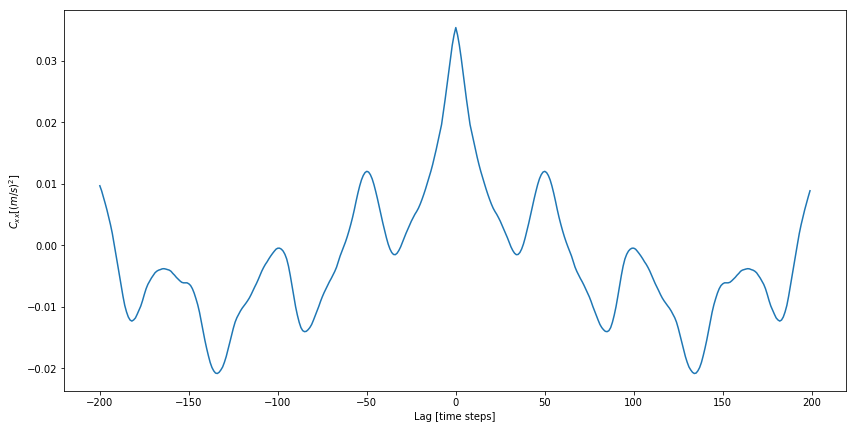

In [26]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx)
ax.set_xlabel('Lag [time steps]')
ax.set_ylabel('$C_{xx} [(m/s)^2]$')

We define the **lag correlation coefficient** as
\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}

This is unitless, and note that $\rho_{xx}(0)=1$.  

(-1, 1)

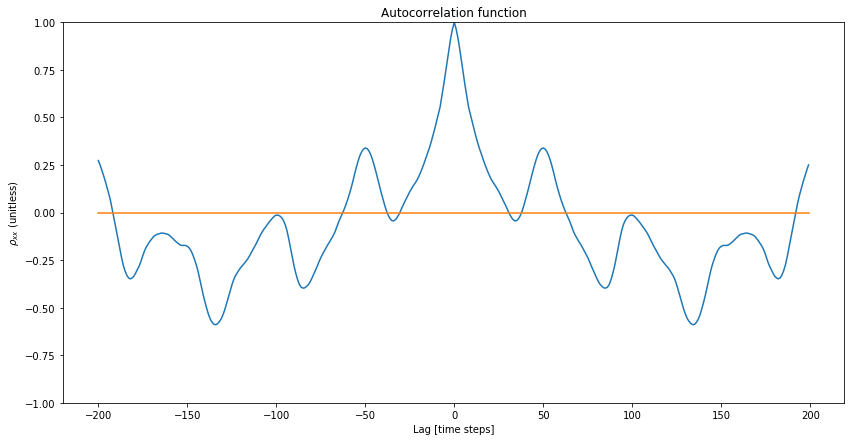

In [27]:
fig,ax=plt.subplots(1,1)

ax.plot(lags,cxx/np.var(rrp))
ax.plot(lags,cxx/np.var(rrp)*0)

ax.set_xlabel('Lag [time steps]')
ax.set_ylabel(r'$\rho_{xx}$ (unitless)')
ax.set_title('Autocorrelation function')

ax.set_ylim([-1,1])

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical "noise"

## Let's look our rain time series

# Postulate an "explanation" of Rain Rate by prior Rain Rate
$rr_t = intercept + c \cdot rr_{t-1} + residual_t$

Text(0.5,1,'RR and prior hour RR')

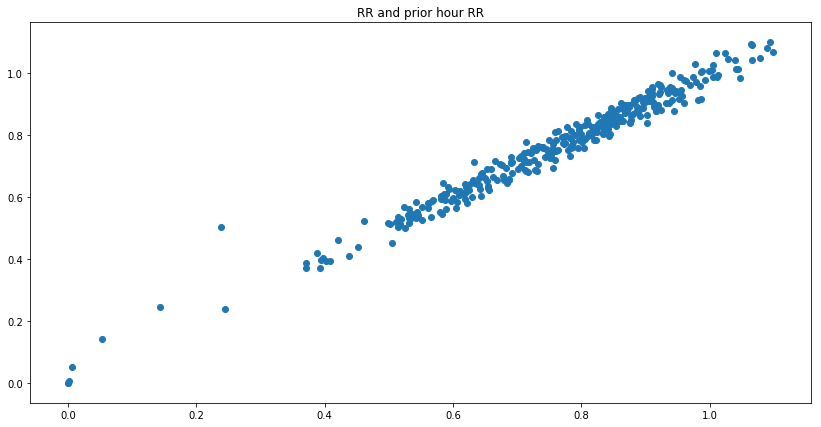

In [28]:
rr = coup_rr_t[0:335] 
rr_1 = coup_rr_t[1:336]

fig,ax = plt.subplots(1,1)

ax.scatter(rr, rr_1)
ax.set_title('RR and prior hour RR')

In [30]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(rr,rr_1)
    
Prediction = intercept + slope*rr_1
print( slope, intercept )
print("r-squared:", r_value**2)

0.9626914704862681 0.030374330404590588
r-squared: 0.9733178634866106


In [31]:
resid = rr - Prediction

Text(0.5,1,'RR and residual of AR1 prediction')

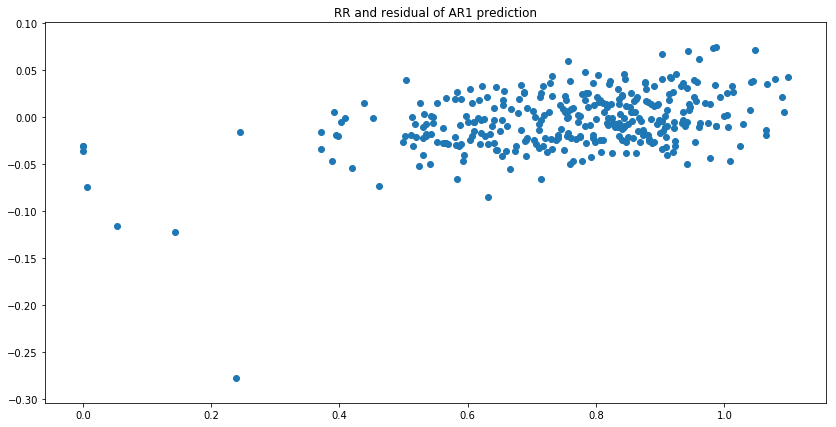

In [32]:
fig,ax = plt.subplots(1,1)

ax.scatter(rr, resid)
ax.set_title('RR and residual of AR1 prediction')

## Not a bad fit -- the residual has little relationship
#### Model the residual with random noise 

In [33]:
sigma = np.std(resid)
FAKE_resid = np.random.randn( len(rr) )*sigma

# Make some fake data
FAKE = rr*0 + np.mean(rr) # right shaped container, mean value

for i in 1+np.arange(len(rr)-1): 
    FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma


Text(0.5,1,'CPAC and AR1: Which is real and which is FAKE?')

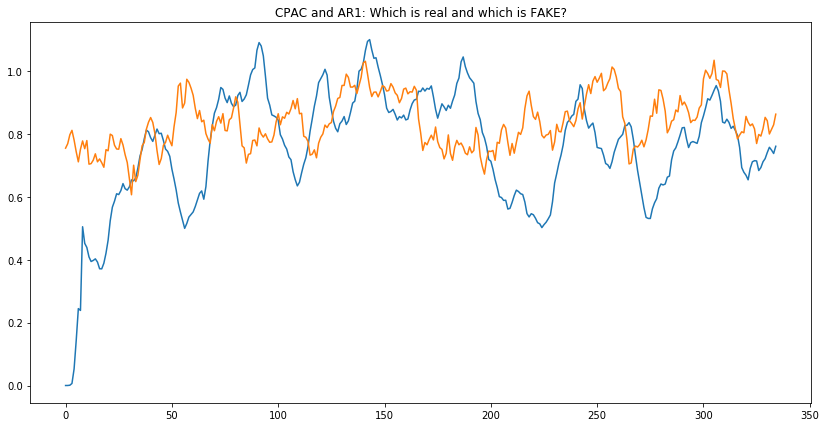

In [36]:
fig,ax=plt.subplots(1,1)
ax.plot(t[0:335], rr)
ax.plot(t[0:335], FAKE)
title('CPAC and AR1: Which is real and which is FAKE?')